# CNN approach for fashion-MNIST

This notebook shows different approaches to solve FashionMNIST problem.


#### Required data
You can find the dataset and further informations at Zalando:
- https://github.com/zalandoresearch/fashion-mnist


_______

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [2]:
#Import options from options.py needed for dataloading and generating models
import sys, os

%run ../code/options.py
%run ../code/util/dataLoader.py

import sys; sys.argv=['']; del sys
args = parseArguments()
print(args)

Call the script from train.py or main.py
Namespace(batch_size=250, exp_name='Experiment_1', img_h=28, img_w=28, load_dir='saved_models', mode='train', model_arch='custom', num_aug=2, num_channels=1, num_classes=10, num_epochs=10, optimizer='Adam', save_dir='saved_models')


# Data Loading

In [3]:
# Generate Data Loader
dataloader = DataLoader(args)
(X_train, y_train), (X_test, y_test) = dataloader.generateData()

#Class mappign usefull for plotting
fashion_classes     = {0: 'T-shirt/top', 
                       1: 'Trouser', 
                       2: 'Pullover', 
                       3: 'Dress', 
                       4: 'Coat',
                       5: 'Sandal', 
                       6: 'Shirt', 
                       7: 'Sneaker', 
                       8: 'Bag', 
                       9: 'Ankle boot'}

Train Samples: 60000
Test Samples: 10000


#### Plot random samples

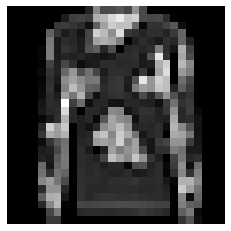

Target: Pullover


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

idx = np.random.randint(len(X_train))
plt.imshow(np.squeeze(X_train[idx]), cmap='gray')
plt.axis('off')
plt.show()

print("Target:", fashion_classes[y_train[idx]])

### Data augmentation (optional)
This method will increase the raw data by data augmentation of images. I just added rotation, horizontal flip and fill mode. Feel free to change these settings. These settings can be found in dataLoader.py
Processing of raw images:
- Scaling pixels between 0.0-1.0
- Add augmentated images

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Perform data Augmentation
X_train_shaped, y_train_shaped = dataloader.preprocess_data(
                                        X_train, y_train, 
                                        use_augmentation=True, 
                                        nb_of_augmentation=args.num_aug
                                        )
X_test_shaped, y_test_shaped   = dataloader.preprocess_data(X_test,  y_test)

Augmenting images...
*Preprocessing completed: 180000 samples

Augmenting images...
*Preprocessing completed: 10000 samples



### Model

#### Generate model now, all models ared defined isnide code/util/model.py

In [12]:
%run ../code/util/model.py

args.model_arch="v1"
model_obj = GenerateModel(args)
cnn_model = model_obj.cnn_model() #Default Architecture is Custom finetuned

cnn_model.summary()

Version 1
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 13, 13, 

<Figure size 432x288 with 0 Axes>

### Run training
Run training for number of iterations by random data for train/validation. The best model of each iteration will be saved as hdf5 checkpoint.

In [7]:
from sklearn.model_selection import train_test_split

histories = []

i=0
# Saving the best checkpoint for each iteration
filepath = "fashion_mnist-%i.hdf5" % i

X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train_shaped, y_train_shaped,
                                                      test_size=0.2, random_state=42)

import time
start = time.time()
history = cnn_model.fit(
    X_train_, y_train_,
    batch_size=args.batch_size,
    epochs=args.num_epochs,
    verbose=1,
    validation_data=(X_val_, y_val_),
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
    ]
)
end = time.time()
print("Total time taken = ", end-start)
histories.append(history.history)

Train on 144000 samples, validate on 36000 samples
Epoch 1/10
143750/144000 [============================>.] - ETA: 0s - loss: 0.5530 - accuracy: 0.8005
Epoch 00001: val_loss improved from inf to 0.31895, saving model to fashion_mnist-0.hdf5
144000/144000 [==============================] - 19s 131us/sample - loss: 0.5527 - accuracy: 0.8005 - val_loss: 0.3190 - val_accuracy: 0.8818
Epoch 2/10
143750/144000 [============================>.] - ETA: 0s - loss: 0.3502 - accuracy: 0.8714
Epoch 00002: val_loss improved from 0.31895 to 0.27703, saving model to fashion_mnist-0.hdf5
144000/144000 [==============================] - 17s 117us/sample - loss: 0.3501 - accuracy: 0.8714 - val_loss: 0.2770 - val_accuracy: 0.8961
Epoch 3/10
143750/144000 [============================>.] - ETA: 0s - loss: 0.3084 - accuracy: 0.8864
Epoch 00003: val_loss improved from 0.27703 to 0.26466, saving model to fashion_mnist-0.hdf5
144000/144000 [==============================] - 17s 117us/sample - loss: 0.3086 - a

# Evaluation

#### Trainingscores for loss and accuracy for all checkpoints are imporved with Data Agmentation
Please remind that checkpoints will be saved by minimum loss.

In [13]:
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)
    
print('Training: \t%0.8f loss / %0.8f acc'   % (get_avg(histories,'loss'), get_avg(histories,'accuracy')))
print('Validation: \t%0.8f loss / %0.8f acc' % (get_avg(histories,'val_loss'), get_avg(histories,'val_accuracy')))

Training: 	0.22014115 loss / 0.91809028 acc
Validation: 	0.18803155 loss / 0.92925000 acc


#### Loss / accuracy of all models on testset
Determine loss and accuracy of all models.

In [14]:
test_loss = []
test_accs = []

for i in range(0,1):
    cnn_ = tf.keras.models.load_model("fashion_mnist-%i.hdf5" % i)
    
    score = cnn_.evaluate(X_test_shaped, y_test_shaped, verbose=0)
    test_loss.append(score[0])
    test_accs.append(score[1])
    
    print('Running final test with model %i: %0.4f loss / %0.4f acc' % (i,score[0],score[1]))
    
print('\nAverage loss / accuracy on testset: %0.4f loss / %0.5f acc' % (np.mean(test_loss),np.mean(test_accs)))
print('Standard deviation: (+-%0.4f) loss / (+-%0.4f) acc' % (np.std(test_loss),np.std(test_accs)))

Running final test with model 0: 0.2179 loss / 0.9182 acc

Average loss / accuracy on testset: 0.2179 loss / 0.91820 acc
Standard deviation: (+-0.0000) loss / (+-0.0000) acc


##### Plotting accuracy and loss for each iteration

In [15]:
def plot_acc_loss(title, histories, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    # Accuracy
    ax1.set_title('Model accuracy (%s)' % title)
    names = []
    for i, model in enumerate(histories):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        names.append('Model %i' % i)
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='upper left')
    
    # Loss
    ax2.set_title('Model loss (%s)' % title)
    for model in histories:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20, 5)
    plt.show()

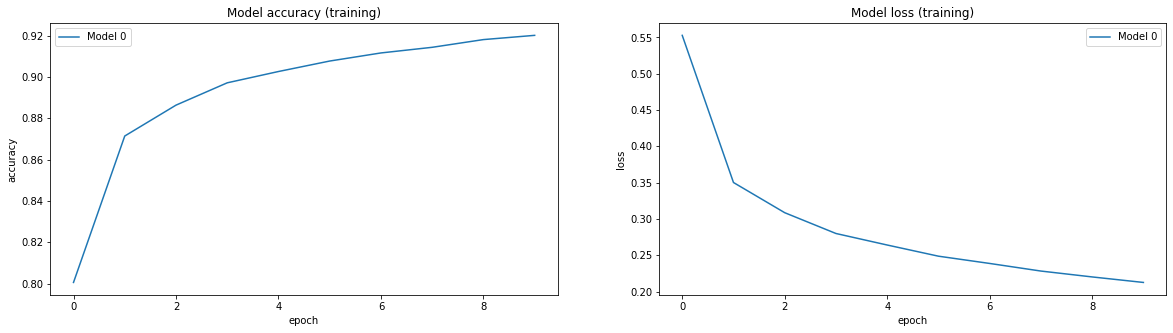

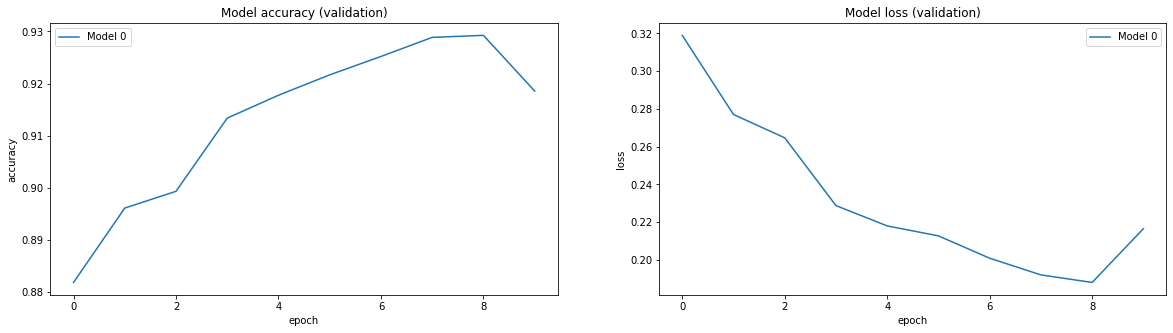

In [11]:
plot_acc_loss('training', histories, 'accuracy', 'loss')
plot_acc_loss('validation', histories, 'val_accuracy', 'val_loss')